In [4]:
#Misterious command that makes everything work
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from tensorflow.keras import backend
print(backend.image_data_format())

channels_last


In [65]:
import os
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import os
import pickle
import numpy as np

In [6]:

batch_size = 32
num_classes = 10
epochs = 100
saveDir = "./saveDir/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [73]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]

y_val = y_test[:7000]
y_test = y_test[7000:]

#Change labels to one-hot encoder
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("label shapes",y_train.shape,y_val.shape,y_test.shape)
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
label shapes (50000, 10) (7000, 10) (3000, 10)
validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


## Add noise to the data

In [9]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

In [10]:
import matplotlib.pyplot as plt
def showOrigDec(orig, noise, num=10):
    
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

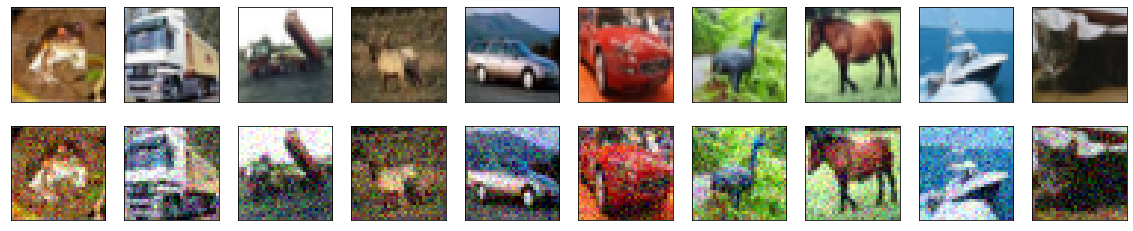

In [11]:
showOrigDec(x_train, x_train_noisy)

## Creating convolution autodenoiser

In [12]:
def createEncoder(input_size):
    input_img = Input(shape=(input_size))
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    #Encoded size (8,8,32)
    return Model(input_img, encoded)
    
def createDecoder(input_size):
    encoded = Input(shape=input_size)
    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    
    return Model(encoded, decoded)
    
def createConvolutionalAutodenoiser(input_size):
    encoder = createEncoder(input_size)
    decoder = createDecoder((8,8,32))
    
    input_img = Input(shape=(input_size))
    encoded_img = encoder(input_img)
    decoded_img = decoder(encoded_img)
    
    model = Model(input_img, decoded_img)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model, encoder, decoder


def createModel():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [13]:
encoder = createEncoder((32,32,3))
print(encoder.summary())

denoiser, encoder, decoder = createConvolutionalAutodenoiser((32,32,3))
print(denoiser.summary())

# model = createModel()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128   

In [18]:
model.load_weights(saveDir + "AutoEncoder_Cifar10_denoise_weights.10-0.55-0.55.hdf5")
es_cb = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_denoise_weights.{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model,encoder, decoder = createConvolutionalAutodenoiser((32,32,3))

history = model.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val_noisy, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

# history = model.fit(x_train_noisy, x_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_val_noisy, x_val),
#                     shuffle=True)

Train on 50000 samples, validate on 7000 samples
Epoch 1/100
49952/50000 [============================>.] - ETA: 0s - loss: 0.5660
Epoch 00001: val_loss improved from inf to 0.56046, saving model to ./saveDir/AutoEncoder_Cifar10_denoise_weights.01-0.57-0.56.hdf5
50000/50000 [==============================] - 13s 260us/sample - loss: 0.5660 - val_loss: 0.5605
Epoch 2/100
49760/50000 [============================>.] - ETA: 0s - loss: 0.5596
Epoch 00002: val_loss improved from 0.56046 to 0.55792, saving model to ./saveDir/AutoEncoder_Cifar10_denoise_weights.02-0.56-0.56.hdf5
50000/50000 [==============================] - 12s 232us/sample - loss: 0.5596 - val_loss: 0.5579
Epoch 3/100
49888/50000 [============================>.] - ETA: 0s - loss: 0.5582
Epoch 00003: val_loss improved from 0.55792 to 0.55759, saving model to ./saveDir/AutoEncoder_Cifar10_denoise_weights.03-0.56-0.56.hdf5
50000/50000 [==============================] - 11s 230us/sample - loss: 0.5582 - val_loss: 0.5576
Epoch 4

Epoch 32/100
49824/50000 [============================>.] - ETA: 0s - loss: 0.5554
Epoch 00032: val_loss did not improve from 0.55495
50000/50000 [==============================] - 12s 237us/sample - loss: 0.5554 - val_loss: 0.5552
Epoch 33/100
49952/50000 [============================>.] - ETA: 0s - loss: 0.5553
Epoch 00033: val_loss did not improve from 0.55495
50000/50000 [==============================] - 13s 250us/sample - loss: 0.5553 - val_loss: 0.5551
Epoch 34/100
49888/50000 [============================>.] - ETA: 0s - loss: 0.5553
Epoch 00034: val_loss did not improve from 0.55495
50000/50000 [==============================] - 12s 233us/sample - loss: 0.5553 - val_loss: 0.5553
Epoch 35/100
49824/50000 [============================>.] - ETA: 0s - loss: 0.5553
Epoch 00035: val_loss did not improve from 0.55495
50000/50000 [==============================] - 12s 232us/sample - loss: 0.5553 - val_loss: 0.5555
Epoch 36/100
49856/50000 [============================>.] - ETA: 0s - lo

Epoch 67/100
49888/50000 [============================>.] - ETA: 0s - loss: 0.5552
Epoch 00067: val_loss did not improve from 0.55475
50000/50000 [==============================] - 11s 228us/sample - loss: 0.5552 - val_loss: 0.5550
Epoch 68/100
49888/50000 [============================>.] - ETA: 0s - loss: 0.5552
Epoch 00068: val_loss did not improve from 0.55475
50000/50000 [==============================] - 11s 227us/sample - loss: 0.5552 - val_loss: 0.5550
Epoch 69/100
49856/50000 [============================>.] - ETA: 0s - loss: 0.5551
Epoch 00069: val_loss did not improve from 0.55475
50000/50000 [==============================] - 12s 231us/sample - loss: 0.5551 - val_loss: 0.5548
Epoch 70/100
49984/50000 [============================>.] - ETA: 0s - loss: 0.5552
Epoch 00070: val_loss did not improve from 0.55475
50000/50000 [==============================] - 11s 229us/sample - loss: 0.5552 - val_loss: 0.5548
Epoch 71/100
49824/50000 [============================>.] - ETA: 0s - lo

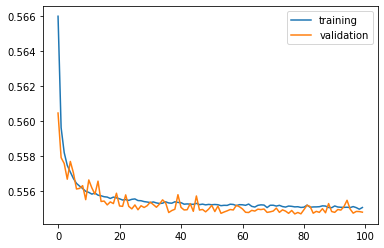

In [24]:
import matplotlib.pyplot as plt
history.history.keys()

fig,ax = plt.subplots(1,1)
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='validation')
ax.legend()

In [89]:
#Create new model
denoiser_best, _, _ = createConvolutionalAutodenoiser((32,32,3))
print(denoiser.summary())

denoiser_best.load_weights(saveDir + "AutoEncoder_Cifar10_denoise_weights.78-0.56-0.55_best.hdf5")

encoder_best = denoiser_best.layers[1]
decoder_best = denoiser_best.layers[2]

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_1 (Model)              (None, 8, 8, 32)          10400     
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 3)         19631     
Total params: 30,031
Trainable params: 29,769
Non-trainable params: 262
_________________________________________________________________
None


In [91]:
encoded_test = encoder_best.predict(x_test_noisy)
c10test = decoder_best.predict(encoded_test)

encoded_val = encoder_best.predict(x_val_noisy)
c10val = decoder_best.predict(encoded_val)

print("Print encoded features shape",encoded_test.shape)
# c10test = model.predict(x_test_noisy)
# c10val = model.predict(x_val_noisy)

# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


Print encoded features shape (3000, 8, 8, 32)


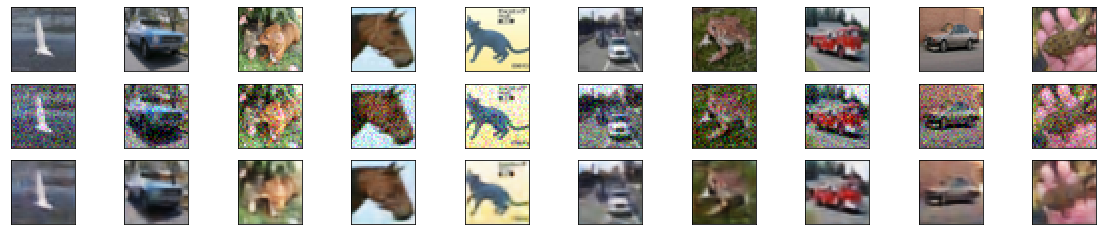

In [92]:
showOrigDec(x_test, x_test_noisy, c10test)

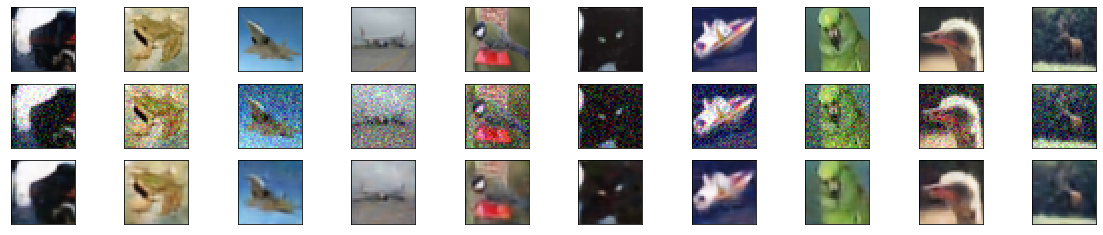

In [94]:
showOrigDec(x_test[100:], x_test_noisy[100:], c10test[100:])

## Training classifier from scratch

### Classification model

In [106]:
def createEncoder(input_size):
    input_img = Input(shape=(input_size))
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    return Model(input_img, encoded)

def create_classification_model(input_size, numb_of_classes, pretrained_encoder=None):
    if pretrained_encoder is None:
        encoder = createEncoder(input_size)
    else:
        encoder = pretrained_encoder
    
    input_img= Input(shape=(input_size))
    x = encoder(input_img) 
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes)(x)
    x = Activation('softmax')(x)
    
    model = Model(input_img, x)
    
    opt_rms = RMSprop(lr=0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=opt_rms, 
                  metrics=['acc'])
    
    return model

In [107]:
classification_model = create_classification_model((32,32,3),10)
classification_model.summary()


Model: "model_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_103 (Model)            (None, 8, 8, 32)          10400     
_________________________________________________________________
flatten_20 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_40 (Dense)             (None, 512)               131584    
_________________________________________________________________
activation_187 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0 

In [108]:
es_cb = EarlyStopping(monitor='val_acc', patience=50, verbose=1, mode='auto')
chkpt = 'saveDirClassification/' + 'ClassifierScratch_Cifar10_denoise_weights.{epoch:02d}-{acc:.4f}-{val_acc:.4f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
batch_size = 64
classification_model = create_classification_model((32,32,3),10)

print(x_train.shape, y_train.shape)
classification_history = classification_model.fit(x=x_train, y=y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        callbacks=[es_cb, cp_cb],
                        shuffle=True)


(50000, 32, 32, 3) (50000, 10)
Train on 50000 samples, validate on 7000 samples
Epoch 1/100
49920/50000 [============================>.] - ETA: 0s - loss: 1.7781 - acc: 0.3877
Epoch 00001: val_acc improved from -inf to 0.31471, saving model to saveDirClassification/ClassifierScratch_Cifar10_denoise_weights.01-0.3879-0.3147.hdf5
50000/50000 [==============================] - 9s 173us/sample - loss: 1.7773 - acc: 0.3879 - val_loss: 2.6639 - val_acc: 0.3147
Epoch 2/100
49984/50000 [============================>.] - ETA: 0s - loss: 1.3249 - acc: 0.5383
Epoch 00002: val_acc improved from 0.31471 to 0.47829, saving model to saveDirClassification/ClassifierScratch_Cifar10_denoise_weights.02-0.5383-0.4783.hdf5
50000/50000 [==============================] - 6s 116us/sample - loss: 1.3248 - acc: 0.5383 - val_loss: 1.6922 - val_acc: 0.4783
Epoch 3/100
49920/50000 [============================>.] - ETA: 0s - loss: 1.1482 - acc: 0.6019
Epoch 00003: val_acc improved from 0.47829 to 0.51071, saving m

Epoch 27/100
49536/50000 [============================>.] - ETA: 0s - loss: 0.5977 - acc: 0.8067
Epoch 00027: val_acc did not improve from 0.66771
50000/50000 [==============================] - 6s 114us/sample - loss: 0.5981 - acc: 0.8067 - val_loss: 2.1226 - val_acc: 0.6060
Epoch 28/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5958 - acc: 0.8083
Epoch 00028: val_acc did not improve from 0.66771
50000/50000 [==============================] - 6s 114us/sample - loss: 0.5959 - acc: 0.8083 - val_loss: 1.7787 - val_acc: 0.6499
Epoch 29/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5878 - acc: 0.8102
Epoch 00029: val_acc did not improve from 0.66771
50000/50000 [==============================] - 6s 113us/sample - loss: 0.5887 - acc: 0.8101 - val_loss: 2.9729 - val_acc: 0.5577
Epoch 30/100
49664/50000 [============================>.] - ETA: 0s - loss: 0.5751 - acc: 0.8157
Epoch 00030: val_acc improved from 0.66771 to 0.67857, saving model to save

Epoch 56/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.5208 - acc: 0.8469
Epoch 00056: val_acc did not improve from 0.68471
50000/50000 [==============================] - 6s 114us/sample - loss: 0.5208 - acc: 0.8469 - val_loss: 2.3721 - val_acc: 0.6676
Epoch 57/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5084 - acc: 0.8508
Epoch 00057: val_acc did not improve from 0.68471
50000/50000 [==============================] - 6s 114us/sample - loss: 0.5084 - acc: 0.8509 - val_loss: 2.4871 - val_acc: 0.6530
Epoch 58/100
49600/50000 [============================>.] - ETA: 0s - loss: 0.5051 - acc: 0.8518
Epoch 00058: val_acc did not improve from 0.68471
50000/50000 [==============================] - 6s 115us/sample - loss: 0.5053 - acc: 0.8516 - val_loss: 2.4251 - val_acc: 0.6574
Epoch 59/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5069 - acc: 0.8546
Epoch 00059: val_acc did not improve from 0.68471
50000/50000 [============

Epoch 86/100
49536/50000 [============================>.] - ETA: 0s - loss: 0.4751 - acc: 0.8660
Epoch 00086: val_acc did not improve from 0.68471
50000/50000 [==============================] - 6s 119us/sample - loss: 0.4749 - acc: 0.8660 - val_loss: 2.7425 - val_acc: 0.6787
Epoch 87/100
49664/50000 [============================>.] - ETA: 0s - loss: 0.4657 - acc: 0.8717
Epoch 00087: val_acc improved from 0.68471 to 0.69586, saving model to saveDirClassification/ClassifierScratch_Cifar10_denoise_weights.87-0.8717-0.6959.hdf5
50000/50000 [==============================] - 6s 114us/sample - loss: 0.4653 - acc: 0.8717 - val_loss: 2.3509 - val_acc: 0.6959
Epoch 88/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.4683 - acc: 0.8690
Epoch 00088: val_acc did not improve from 0.69586
50000/50000 [==============================] - 6s 116us/sample - loss: 0.4679 - acc: 0.8691 - val_loss: 2.4292 - val_acc: 0.6926
Epoch 89/100
49856/50000 [============================>.] - ETA: 

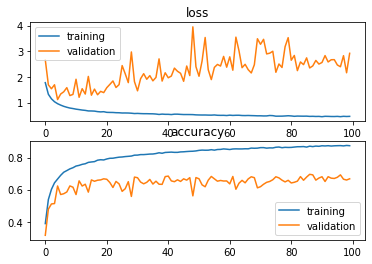

In [109]:
import matplotlib.pyplot as plt
history.history.keys()

fig,ax = plt.subplots(2,1)
ax[0].set_title("loss")
ax[0].plot(classification_history.history['loss'], label='training')
ax[0].plot(classification_history.history['val_loss'], label='validation')
ax[0].legend()

ax[1].set_title("accuracy")
ax[1].plot(classification_history.history['acc'], label='training')
ax[1].plot(classification_history.history['val_acc'], label='validation')
ax[1].legend()

## Using Encoder as a feature extractor for classification.


In [110]:
#Create autoencoder
denoiser_best, _, _ = createConvolutionalAutodenoiser((32,32,3))
# print(denoiser.summary())
denoiser_best.load_weights(saveDir + "AutoEncoder_Cifar10_denoise_weights.78-0.56-0.55_best.hdf5")
encoder_best = denoiser_best.layers[1]

for l in encoder_best.layers:
    l.trainable = False
    
#Create classification model
classification_model_with_denoising = create_classification_model((32,32,3),2,pretrained_encoder=encoder_best)
classification_model_with_denoising.summary()

Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_114 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_107 (Model)            (None, 8, 8, 32)          10400     
_________________________________________________________________
flatten_22 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_46 (Dense)             (None, 512)               131584    
_________________________________________________________________
activation_198 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0 

In [111]:
es_cb = EarlyStopping(monitor='val_acc', patience=50, verbose=1, mode='auto')
chkpt = 'saveDirClassification/' + 'ClassifierScratch_Cifar10_denoise_weights.{epoch:02d}-{acc:.4f}-{val_acc:.4f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
batch_size = 64

print(x_train.shape, y_train.shape)
classification_history_2 = classification_model_with_denoising.fit(x=x_train, y=y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        callbacks=[es_cb, cp_cb],
                        shuffle=True)

(50000, 32, 32, 3) (50000, 10)
Train on 50000 samples, validate on 7000 samples
Epoch 1/100
49408/50000 [============================>.] - ETA: 0s - loss: 2.5046 - acc: 0.1401
Epoch 00001: val_acc improved from -inf to 0.23686, saving model to saveDirClassification/ClassifierScratch_Cifar10_denoise_weights.01-0.1404-0.2369.hdf5
50000/50000 [==============================] - 6s 119us/sample - loss: 2.5029 - acc: 0.1404 - val_loss: 1.9693 - val_acc: 0.2369
Epoch 2/100
49984/50000 [============================>.] - ETA: 0s - loss: 2.0967 - acc: 0.2067
Epoch 00002: val_acc did not improve from 0.23686
50000/50000 [==============================] - 5s 92us/sample - loss: 2.0965 - acc: 0.2068 - val_loss: 2.1627 - val_acc: 0.2113
Epoch 3/100
49984/50000 [============================>.] - ETA: 0s - loss: 2.0256 - acc: 0.2288
Epoch 00003: val_acc improved from 0.23686 to 0.27357, saving model to saveDirClassification/ClassifierScratch_Cifar10_denoise_weights.03-0.2288-0.2736.hdf5
50000/50000 [=

Epoch 28/100
49600/50000 [============================>.] - ETA: 0s - loss: 1.9675 - acc: 0.3225
Epoch 00028: val_acc did not improve from 0.43986
50000/50000 [==============================] - 5s 94us/sample - loss: 1.9739 - acc: 0.3224 - val_loss: 1.6612 - val_acc: 0.3949
Epoch 29/100
49600/50000 [============================>.] - ETA: 0s - loss: 1.9705 - acc: 0.3251
Epoch 00029: val_acc did not improve from 0.43986
50000/50000 [==============================] - 5s 95us/sample - loss: 1.9708 - acc: 0.3249 - val_loss: 1.6820 - val_acc: 0.3397
Epoch 30/100
49600/50000 [============================>.] - ETA: 0s - loss: 1.9460 - acc: 0.3225
Epoch 00030: val_acc did not improve from 0.43986
50000/50000 [==============================] - 5s 93us/sample - loss: 1.9445 - acc: 0.3228 - val_loss: 1.6585 - val_acc: 0.3891
Epoch 31/100
49664/50000 [============================>.] - ETA: 0s - loss: 1.9712 - acc: 0.3219
Epoch 00031: val_acc did not improve from 0.43986
50000/50000 [===============

Epoch 58/100
49920/50000 [============================>.] - ETA: 0s - loss: 1.9620 - acc: 0.3146
Epoch 00058: val_acc did not improve from 0.43986
50000/50000 [==============================] - 5s 93us/sample - loss: 1.9618 - acc: 0.3146 - val_loss: 1.9924 - val_acc: 0.2760
Epoch 59/100
49664/50000 [============================>.] - ETA: 0s - loss: 1.9558 - acc: 0.3151
Epoch 00059: val_acc did not improve from 0.43986
50000/50000 [==============================] - 5s 96us/sample - loss: 1.9543 - acc: 0.3155 - val_loss: 7.1358 - val_acc: 0.2271
Epoch 60/100
49984/50000 [============================>.] - ETA: 0s - loss: 1.9991 - acc: 0.3200
Epoch 00060: val_acc did not improve from 0.43986
50000/50000 [==============================] - 5s 97us/sample - loss: 1.9991 - acc: 0.3200 - val_loss: 1.7937 - val_acc: 0.3413
Epoch 61/100
49792/50000 [============================>.] - ETA: 0s - loss: 1.9774 - acc: 0.3167
Epoch 00061: val_acc did not improve from 0.43986
50000/50000 [===============

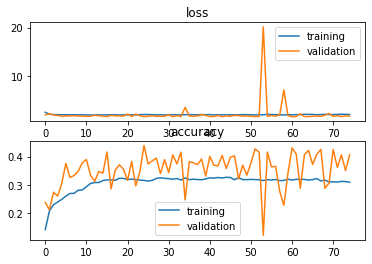

In [112]:
import matplotlib.pyplot as plt
history.history.keys()

fig,ax = plt.subplots(2,1)
ax[0].set_title("loss")
ax[0].plot(classification_history_2.history['loss'], label='training')
ax[0].plot(classification_history_2.history['val_loss'], label='validation')
ax[0].legend()

ax[1].set_title("accuracy")
ax[1].plot(classification_history_2.history['acc'], label='training')
ax[1].plot(classification_history_2.history['val_acc'], label='validation')
ax[1].legend()

## Last test using the pretrained denoiser, but not freezing the layers

In [113]:
#Create autoencoder
denoiser_best, _, _ = createConvolutionalAutodenoiser((32,32,3))
denoiser_best.load_weights(saveDir + "AutoEncoder_Cifar10_denoise_weights.78-0.56-0.55_best.hdf5")
encoder_best = denoiser_best.layers[1]

#Create classification model
classification_model_with_denoising = create_classification_model((32,32,3),2,pretrained_encoder=encoder_best)
classification_model_with_denoising.summary()

es_cb = EarlyStopping(monitor='val_acc', patience=50, verbose=1, mode='auto')
chkpt = 'saveDirClassification/' + 'ClassifierScratch_Cifar10_denoise_weights.{epoch:02d}-{acc:.4f}-{val_acc:.4f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
batch_size = 64

print(x_train.shape, y_train.shape)
classification_history_2 = classification_model_with_denoising.fit(x=x_train, y=y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        callbacks=[es_cb, cp_cb],
                        shuffle=True)


Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_118 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_111 (Model)            (None, 8, 8, 32)          10400     
_________________________________________________________________
flatten_23 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_49 (Dense)             (None, 512)               131584    
_________________________________________________________________
activation_205 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0 

Epoch 21/100
49600/50000 [============================>.] - ETA: 0s - loss: 0.7378 - acc: 0.7440
Epoch 00021: val_acc improved from 0.67171 to 0.68171, saving model to saveDirClassification/ClassifierScratch_Cifar10_denoise_weights.21-0.7442-0.6817.hdf5
50000/50000 [==============================] - 6s 115us/sample - loss: 0.7376 - acc: 0.7442 - val_loss: 1.0766 - val_acc: 0.6817
Epoch 22/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.7206 - acc: 0.7476
Epoch 00022: val_acc did not improve from 0.68171
50000/50000 [==============================] - 6s 115us/sample - loss: 0.7212 - acc: 0.7475 - val_loss: 1.1899 - val_acc: 0.6476
Epoch 23/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.7104 - acc: 0.7508
Epoch 00023: val_acc did not improve from 0.68171
50000/50000 [==============================] - 6s 114us/sample - loss: 0.7102 - acc: 0.7508 - val_loss: 1.0577 - val_acc: 0.6816
Epoch 24/100
49728/50000 [============================>.] - ETA: 

Epoch 50/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.5766 - acc: 0.8073
Epoch 00050: val_acc did not improve from 0.68514
50000/50000 [==============================] - 6s 115us/sample - loss: 0.5768 - acc: 0.8072 - val_loss: 1.9989 - val_acc: 0.5933
Epoch 51/100
49792/50000 [============================>.] - ETA: 0s - loss: 0.5700 - acc: 0.8099
Epoch 00051: val_acc did not improve from 0.68514
50000/50000 [==============================] - 6s 115us/sample - loss: 0.5704 - acc: 0.8099 - val_loss: 1.4013 - val_acc: 0.6681
Epoch 52/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5716 - acc: 0.8078
Epoch 00052: val_acc did not improve from 0.68514
50000/50000 [==============================] - 6s 114us/sample - loss: 0.5707 - acc: 0.8080 - val_loss: 2.0288 - val_acc: 0.6310
Epoch 53/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5651 - acc: 0.8105
Epoch 00053: val_acc did not improve from 0.68514
50000/50000 [============

Epoch 80/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5460 - acc: 0.8264
Epoch 00080: val_acc did not improve from 0.68514
50000/50000 [==============================] - 6s 114us/sample - loss: 0.5456 - acc: 0.8265 - val_loss: 1.7688 - val_acc: 0.6770
Epoch 81/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5438 - acc: 0.8274
Epoch 00081: val_acc did not improve from 0.68514
50000/50000 [==============================] - 6s 114us/sample - loss: 0.5440 - acc: 0.8273 - val_loss: 1.5976 - val_acc: 0.6697
Epoch 82/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5380 - acc: 0.8290
Epoch 00082: val_acc did not improve from 0.68514
50000/50000 [==============================] - 6s 115us/sample - loss: 0.5381 - acc: 0.8290 - val_loss: 5.3364 - val_acc: 0.4834
Epoch 83/100
49728/50000 [============================>.] - ETA: 0s - loss: 0.5439 - acc: 0.8275
Epoch 00083: val_acc did not improve from 0.68514
50000/50000 [============

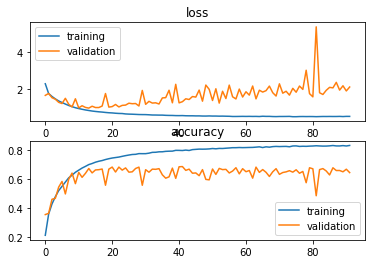

In [114]:
#plot
fig,ax = plt.subplots(2,1)
ax[0].set_title("loss")
ax[0].plot(classification_history_2.history['loss'], label='training')
ax[0].plot(classification_history_2.history['val_loss'], label='validation')
ax[0].legend()

ax[1].set_title("accuracy")
ax[1].plot(classification_history_2.history['acc'], label='training')
ax[1].plot(classification_history_2.history['val_acc'], label='validation')
ax[1].legend()